The plots saved by this notebook are called "LDB", which stands for "large database".

In [10]:
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
import random

In [11]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [12]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [13]:
sim[-1]

<TimeStep 'Tempest.9f11c.all.DD/DD2427/DD2427' z=0.00 t=13.76 Gyr>

In [14]:
sim[-1][1].keys()

['consistent_trees_id',
 'Mvir',
 'Mtot',
 'M200c',
 'Rvir',
 'X',
 'Y',
 'Z',
 'X_cu',
 'Y_cu',
 'Z_cu',
 'VX',
 'VY',
 'VZ',
 'Spin_DM_B',
 'Center',
 'Center_cu',
 'consistent_trees_link']

In [15]:
sats = sim[-1][1].calculate('Satellites()')
print(sats)

[<Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_87' | NDM=110 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_54' | NDM=171 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_21' | NDM=517 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_109' | NDM=84 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_50' | NDM=183 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_12' | NDM=1357 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_115' | NDM=78 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_118' | NDM=75 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_99' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_73' | NDM=139 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_100' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_51' | NDM=182 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_113' | NDM=82 Ns

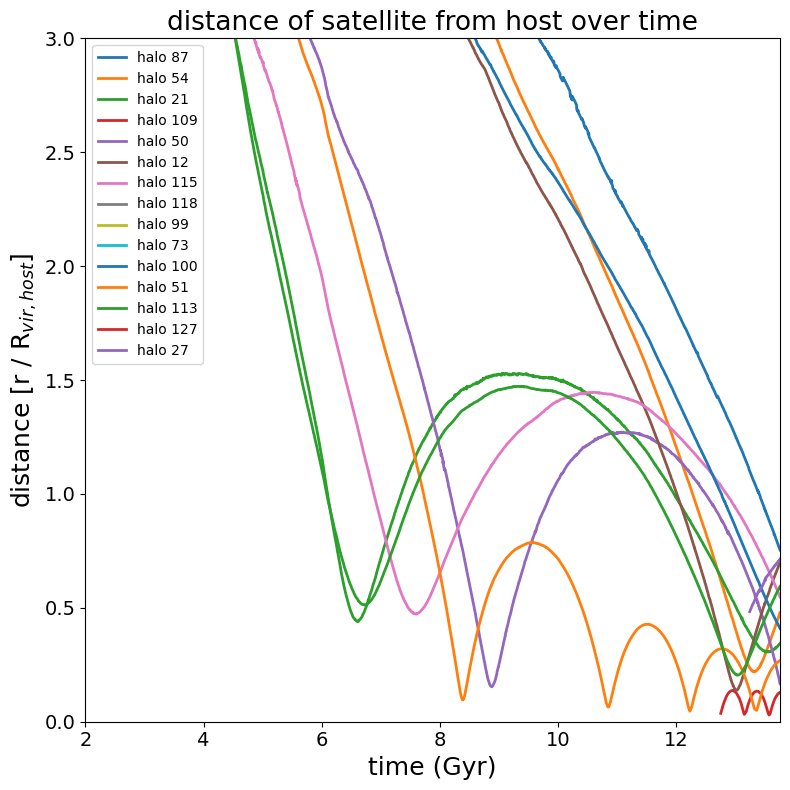

In [16]:
'''
This cell plots the distance of each satellite from the host (Tempest) over time
'''

fig, ax = plt.subplots(figsize=(8,8))

i = 0
while i < np.size(sats):
    
    # this finds the index of each of the satellite halos
    
    idx = sats[i].halo_number
    
    # this finds the index of the host for each of the satellite halos. the index should be
    # the same for all haloes, but this is coded separately to account for the case where
    # the host halo changes index as its mass profile evolves.
    
    host = sats[i].calculate('Hosts()')
    host_idx = host[0].halo_number
    
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    
    host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                    sim[-1][host_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
    sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                    sim[-1][idx].calculate_for_progenitors('Mvir', 'X', 'Y', 'Z', 't()')
    
    # now, we have to correct for the distance of the satellite halos from the host halo, which itself
    # is also moving. to do this, we need to subtract the position of the satellite by the position of
    # the host. 
    # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract
    
    ### this checks for non-overlapping redshifts between host and satellite. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(host_t)):
        if host_t[j] not in sat_t: 
            host_t[j] = 0.
            host_x[j] = 0.
            host_y[j] = 0.
            host_z[j] = 0.
            host_rvir[j] = 0.
    
    ### this checks for non-overlapping redshifts between satellite and host. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_t)):
        if sat_t[k] not in host_t:
            sat_t[k] = 0.
            sat_x[k] = 0.
            sat_y[k] = 0.
            sat_z[k] = 0.
            
    ### this removes all the zeros
    host_t = host_t[host_t != 0.]
    host_x = host_x[host_x != 0.]
    host_y = host_y[host_y != 0.]
    host_z = host_z[host_z != 0.]
    host_rvir = host_rvir[host_rvir != 0.]
    sat_t = sat_t[sat_t != 0.]
    sat_x = sat_x[sat_x != 0.]
    sat_y = sat_y[sat_y != 0.]
    sat_z = sat_z[sat_z != 0.]
    
    # here comes the actual subtracting correction
    sat_x = sat_x - host_x
    sat_y = sat_y - host_y
    sat_z = sat_z - host_z
    
    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)
    
    # this plots distance vs. time for each halo with regard to their host halo
    ratio = sat_r * 1000 / host_rvir
    in_rvir = ratio <= 1
    out_rvir = ratio > 1
    plt.plot(sat_t, (sat_r * 1000 / host_rvir), linewidth=2, label='halo ' + str(idx))
    i += 1
    
plt.legend(loc='upper left', prop={'size': 10})
plt.title('distance of satellite from host over time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim(0, 3)
plt.xlim(2, max(sat_t))
plt.tight_layout()
plt.style.use('default')
plt.savefig('LDB_satellite_over_time.png')

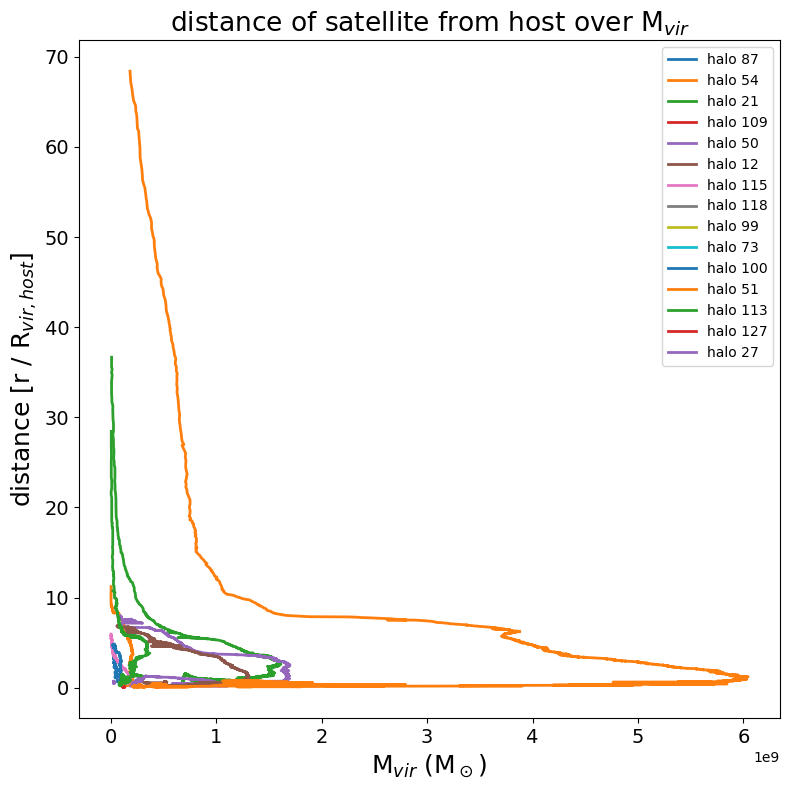

In [8]:
'''
This cell plots the distance of each satellite from the host (Tempest) over time
'''

fig, ax = plt.subplots(figsize=(8,8))

i = 0
while i < np.size(sats):
    
    # this finds the index of each of the satellite halos
    
    idx = sats[i].halo_number
    
    # this finds the index of the host for each of the satellite halos. the index should be
    # the same for all haloes, but this is coded separately to account for the case where
    # the host halo changes index as its mass profile evolves.
    
    host = sats[i].calculate('Hosts()')
    host_idx = host[0].halo_number
    
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    
    host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                    sim[-1][host_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
    sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                    sim[-1][idx].calculate_for_progenitors('Mvir', 'X', 'Y', 'Z', 't()')
    
    # now, we have to correct for the distance of the satellite halos from the host halo, which itself
    # is also moving. to do this, we need to subtract the position of the satellite by the position of
    # the host. 
    # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract
    
    ### this checks for non-overlapping redshifts between host and satellite. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(host_t)):
        if host_t[j] not in sat_t: 
            host_t[j] = 0.
            host_x[j] = 0.
            host_y[j] = 0.
            host_z[j] = 0.
            host_rvir[j] = 0.
            host_mvir[j] = 0.
    
    ### this checks for non-overlapping redshifts between satellite and host. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_t)):
        if sat_t[k] not in host_t:
            sat_t[k] = 0.
            sat_x[k] = 0.
            sat_y[k] = 0.
            sat_z[k] = 0.
            sat_mvir[k] = 0.
            
    ### this removes all the zeros
    host_t = host_t[host_t != 0.]
    host_x = host_x[host_x != 0.]
    host_y = host_y[host_y != 0.]
    host_z = host_z[host_z != 0.]
    host_rvir = host_rvir[host_rvir != 0.]
    host_mvir = host_mvir[host_mvir != 0.]
    sat_t = sat_t[sat_t != 0.]
    sat_x = sat_x[sat_x != 0.]
    sat_y = sat_y[sat_y != 0.]
    sat_z = sat_z[sat_z != 0.]
    sat_mvir = sat_mvir[sat_mvir != 0.]
    
    # here comes the actual subtracting correction
    sat_x = sat_x - host_x
    sat_y = sat_y - host_y
    sat_z = sat_z - host_z
    
    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)
    
    # this plots distance vs. time for each halo with regard to their host halo
    plt.plot(sat_mvir, (sat_r * 1000 / host_rvir), linewidth=2, label='halo ' + str(idx))
    i += 1
    
plt.legend(loc='upper right', prop={'size': 10})
plt.title('distance of satellite from host over M$_{vir}$', fontsize=19)
plt.xlabel('M$_{vir}$ (M$_\odot$)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
#plt.ylim(0, 3)
#plt.xlim(2, max(sat_t))
plt.tight_layout()
plt.style.use('default')
plt.savefig('LDB_satellite_over_mvir.png')

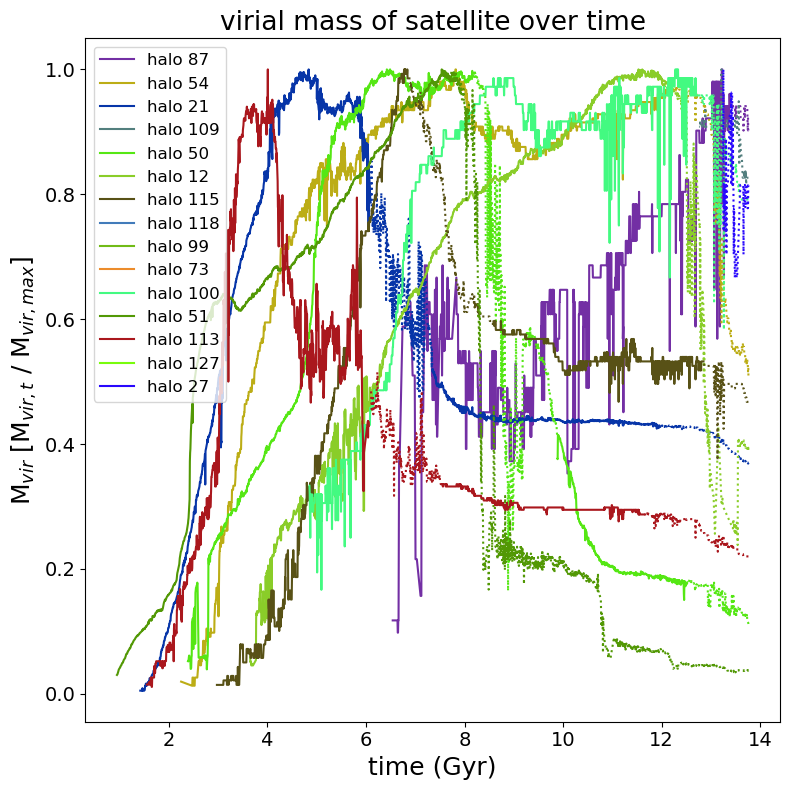

In [9]:
'''
This cell plots the virial mass of each satellite from the host (Tempest) over time
'''

fig, ax = plt.subplots(figsize=(8,8))

i = 0
while i < np.size(sats):
   
    # this finds the index of each of the satellite halos
    idx = sats[i].halo_number
    
    # this finds the index of the host for each of the satellite halos. the index should be
    # the same for all haloes, but this is coded separately to account for the case where
    # the host halo changes index as its mass profile evolves.
    
    host = sats[i].calculate('Hosts()')
    host_idx = host[0].halo_number
    
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    
    host_mvir, host_rvir, host_x, host_y, host_z, host_t = \
                    sim[-1][host_idx].calculate_for_progenitors('Mvir', 'Rvir', 'X', 'Y', 'Z', 't()')
    sat_mvir, sat_rvir, sat_x, sat_y, sat_z, sat_t = \
                    sim[-1][idx].calculate_for_progenitors('Mvir', 'Rvir', 'X', 'Y', 'Z', 't()')
    
    # now, we have to correct for the distance of the satellite halos from the host halo, which itself
    # is also moving. to do this, we need to subtract the position of the satellite by the position of
    # the host. 
    # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract
    
    ### this checks for non-overlapping redshifts between host and satellite. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(host_t)):
        if host_t[j] not in sat_t: 
            host_t[j] = 0.
            host_x[j] = 0.
            host_y[j] = 0.
            host_z[j] = 0.
            host_mvir[j] = 0.
            host_rvir[j] = 0.
    
    ### this checks for non-overlapping redshifts between satellite and host. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_t)):
        if sat_t[k] not in host_t:
            sat_t[k] = 0.
            sat_x[k] = 0.
            sat_y[k] = 0.
            sat_z[k] = 0.
            sat_mvir[k] = 0.
            sat_rvir[k] = 0.
            
    ### this removes all the zeros
    host_t = host_t[host_t != 0.]
    host_x = host_x[host_x != 0.]
    host_y = host_y[host_y != 0.]
    host_z = host_z[host_z != 0.]
    host_mvir = host_mvir[host_mvir != 0.]
    host_rvir = host_rvir[host_rvir != 0.]
    sat_t = sat_t[sat_t != 0.]
    sat_x = sat_x[sat_x != 0.]
    sat_y = sat_y[sat_y != 0.]
    sat_z = sat_z[sat_z != 0.]
    sat_mvir = sat_mvir[sat_mvir != 0.]
    
    # here comes the actual subtracting correction
    sat_x = sat_x - host_x
    sat_y = sat_y - host_y
    sat_z = sat_z - host_z
    
    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)
        
    # this plots distance vs. time for each halo with regard to their host halo
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    radius_ratio = sat_r * 1000 / host_rvir
    mass_ratio = sat_mvir / max(sat_mvir)
    in_rvir = radius_ratio <= 1
    out_rvir = radius_ratio > 1
      
    plt.plot(sat_t, np.ma.masked_where(in_rvir, mass_ratio), linestyle='-', c=color, label='halo ' + str(idx))
    plt.plot(sat_t, np.ma.masked_where(out_rvir, mass_ratio), linestyle=':', c=color)
    i += 1
    
plt.legend(loc='upper left', prop={'size': 12})
plt.title('virial mass of satellite over time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir}$ [M$_{vir,t}$ / M$_{vir,max}$]', fontsize=18)
plt.yticks(fontsize=14)
#plt.xlim(6, max(sat_t))
plt.tight_layout()
plt.style.use('default')
plt.savefig('LDB_satellite_mvir_over_time.png')